## Uninteresting Example
Running the particle filter on real flu data. 

However, we don't have anything to compare it to, as the Trend Forecasting is not in place yet.

In [7]:
from src import run_particle_filter

run_particle_filter.main(location_code='04', 
                         target_date='2023-10-28', 
                         num_particles=100)

Error loading state populations: name 'config' is not defined


NameError: name 'config' is not defined

In [31]:
"""Plotting"""
import seaborn as sns
import pandas as pd

df = pd.read_csv("../output/pf_avg_betas/04/2023-10-28_avg_betas.csv", header=None)
df.rename(columns={0: "pf_avg_beta"}, inplace=True)
list(df.columns)

['pf_avg_beta']

<Axes: >

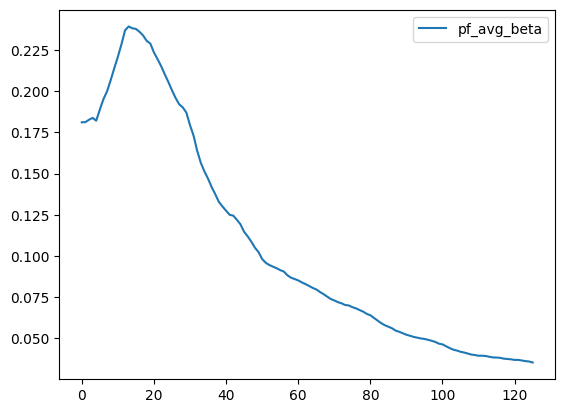

In [33]:
sns.lineplot(data=df)

## Integrating the PF with SPHERE

I installed SPHERE as a package using PIP. 
I hard-coded beta as a constant 0.2. Not seen below. 

In [1]:
from sphere.model.model_factory import ModelFactory
from sphere.parameters.parameters import SIRHParameters
from sphere.solvers.implementations import EulerSolver

params = SIRHParameters()
sirh = ModelFactory.create_model(model_type="SIRH",
                                 params=params,
                                 solver_cls=EulerSolver)
az_population = 7151502
sirh.run(x0=[az_population * 0.98, az_population * 0.02, 0, 0, 0],
         t0=0,
         t_final=149,
         dt=1.0)

Running Model: 100%|██████████| 149/149 [00:00<00:00, 238.58it/s]

Model.run() was successful. Data is accessible at Model.output.states. Plot the output with Model.output.plot_states().


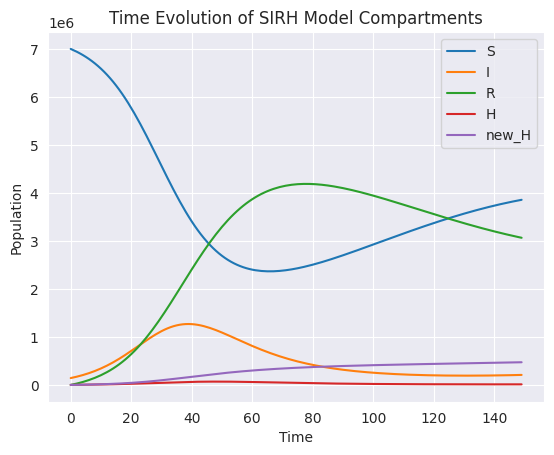

In [2]:
sirh.output.plot_states()

In [3]:
sirh.output.observations.shape

(150,)

In [4]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(state_population=az_population,
                                     location_code='04',
                                     target_date='2047-10-28',
                                     runtime=150,
                                     likelihood_r=10,
                                     likelihood_p=0.3)

In [5]:
observations = sirh.output.observations.tolist()
observations = [round(obs) for obs in observations]

In [6]:
betas, _, states = pf_algo.run(observation_data=observations)  

Running Particle Filter: 100%|██████████| 150/150 [01:19<00:00,  1.90it/s]


In [7]:
import numpy as np
generated_data = sirh.output.states
all_data = np.zeros((150, 6))
all_data[:, 0:5] = generated_data
all_data[:, 5] = [0.2 for _ in range(150)]

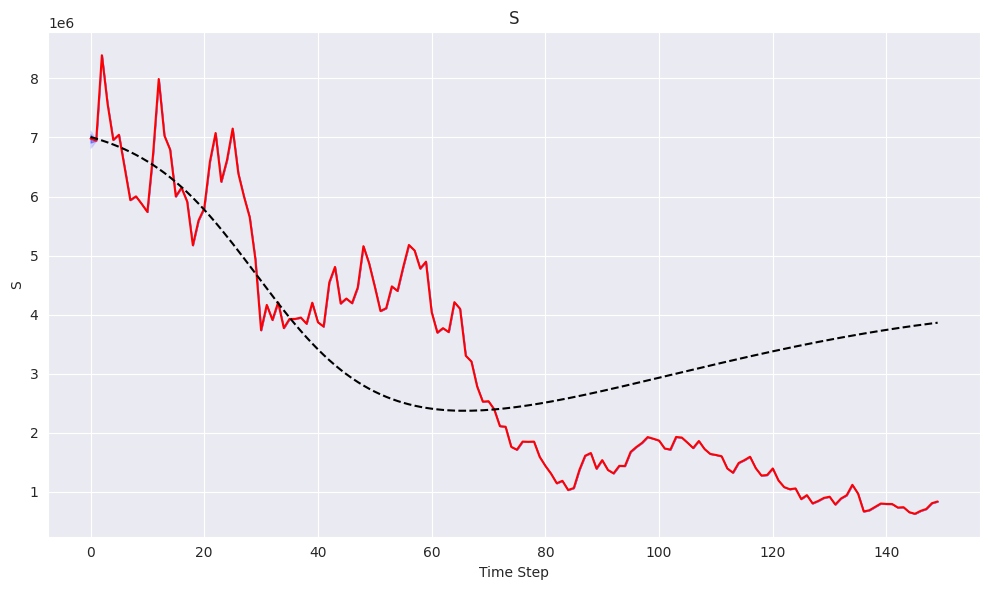

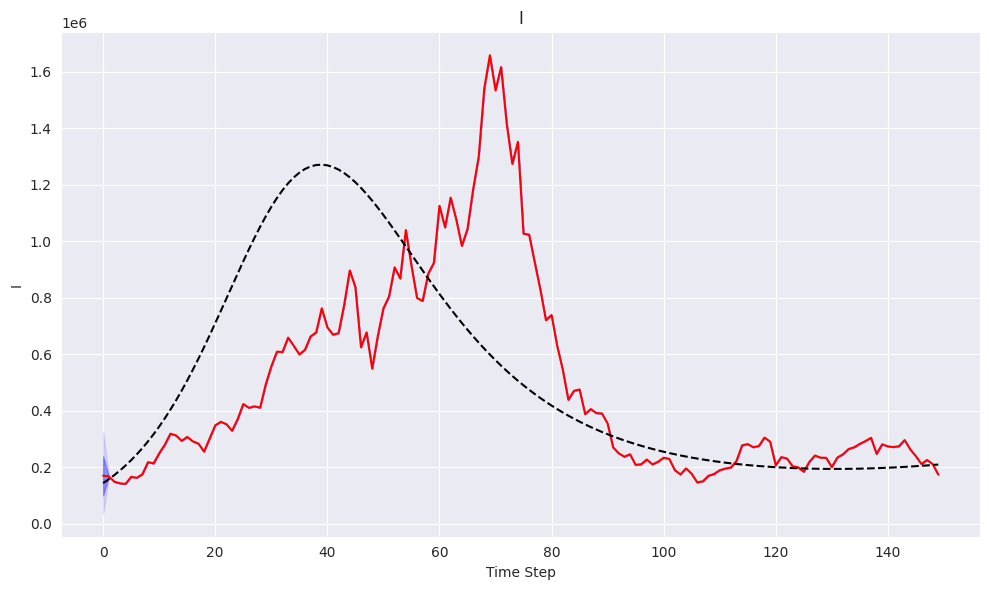

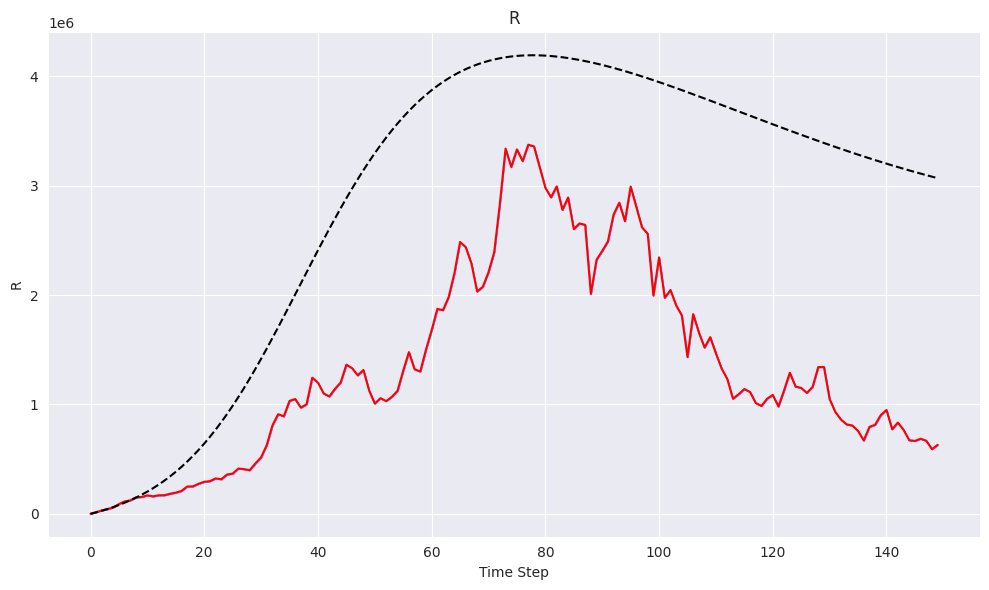

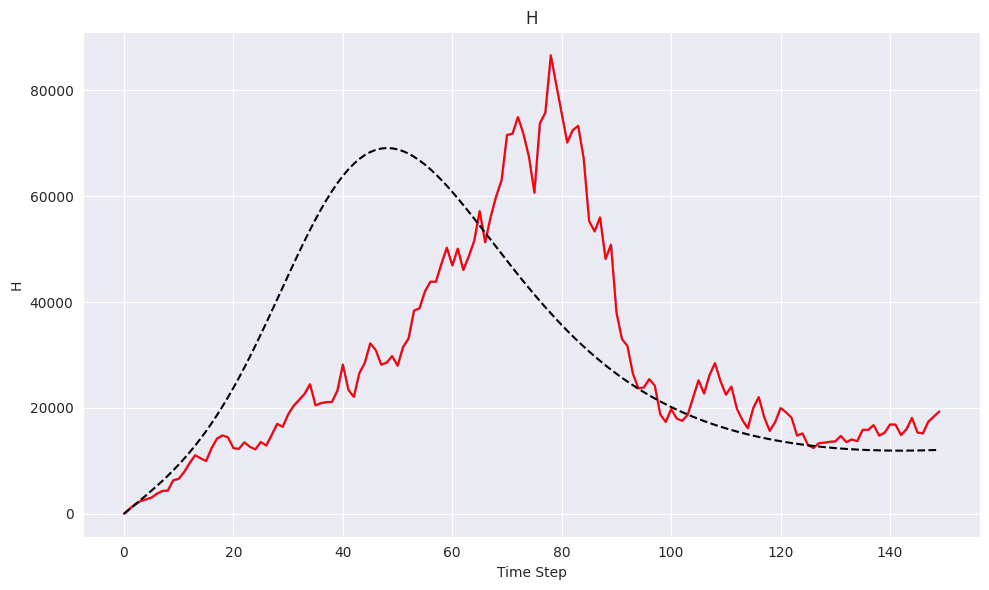

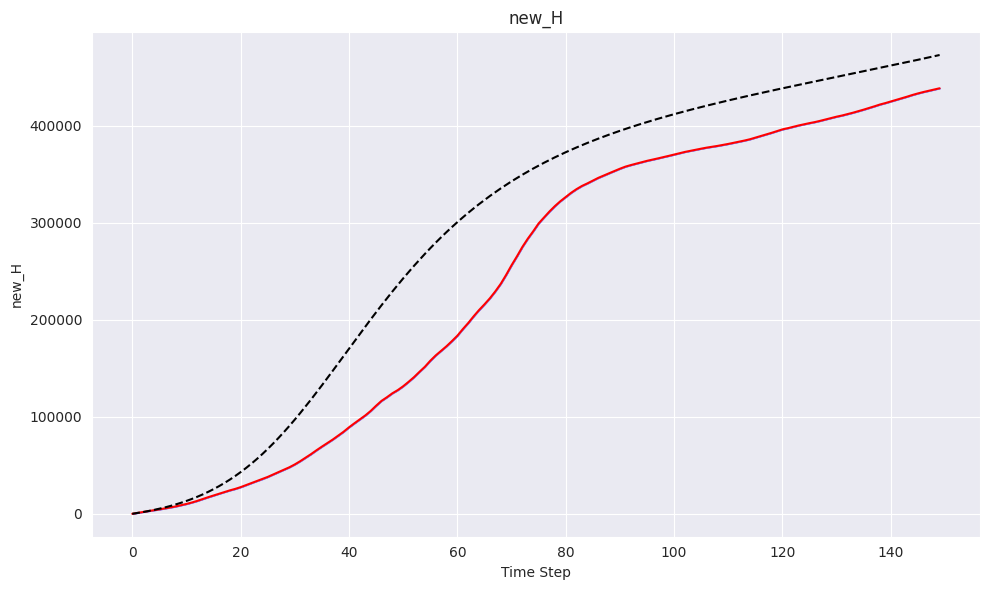

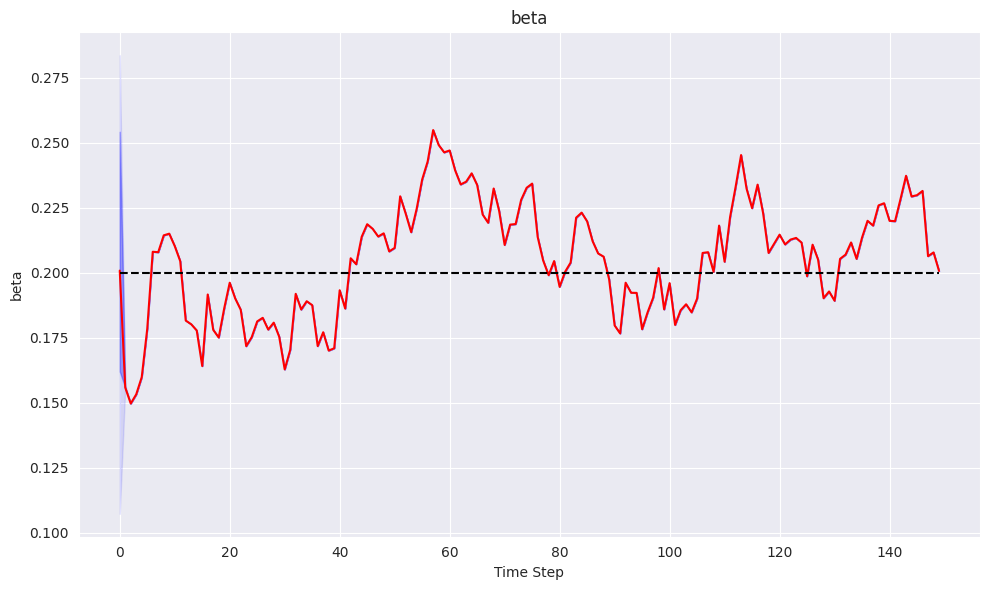

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Number of particles, state variables, and time steps
N, S, T = states.shape

# Labels for the state vector
state_labels = ['S', 'I', 'R', 'H', 'new_H', 'beta']

# Define quantiles
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

# Plot each state variable separately
for i in range(S):
    data = states[:, i, :]  # Shape (N, T)
    
    # Calculate quantiles
    quantile_values = np.percentile(data, [q * 100 for q in quantiles], axis=0)
    
    # Create a new figure
    plt.figure(figsize=(10, 6))
    
    # Fill areas between quantiles
    plt.fill_between(np.arange(T), quantile_values[0], quantile_values[-1], color='blue', alpha=0.1)
    plt.fill_between(np.arange(T), quantile_values[1], quantile_values[-2], color='blue', alpha=0.3)
    plt.plot(np.arange(T), quantile_values[2], color='red')  # Median
    plt.plot(np.arange(T), all_data[:, i], color='black', linestyle='--')  # true data
    
    plt.title(state_labels[i])
    plt.xlabel('Time Step')
    plt.ylabel(state_labels[i])
    
    # Save the plot
    plt.tight_layout()
    plt.show()
    plt.close()
